In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb # XGBoost implementation
from subprocess import check_output
from scipy.stats import norm, lognorm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import operator

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load the dataset and create lists with the features.

In [2]:
# read data
# Input data files are available in the "../input/" directory.
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

features = [x for x in train.columns if x not in ['id','loss']]

cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss']]
num_features = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss']]

Now let's see if the loss follows a log-normal distribution!

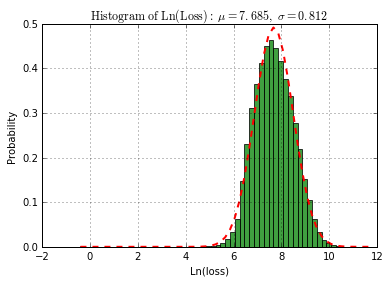

In [3]:
train['log_loss'] = np.log(train['loss'])

# fit the normal distribution on ln(loss)
(mu, sigma) = norm.fit(train['log_loss'])

# the histogram of the ln(loss)
n, bins, patches = plt.hist(train['log_loss'], 60, normed=1, facecolor='green', alpha=0.75)

# add the fitted line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Ln(loss)')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Ln(Loss):}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

Yepp! It's not perfect, but works for me. It's important to change the target variable in this way as RMSE algorithms (default for all regressions) prefer symmetric data: asymmetric output would bias the prediction towards higher losses.

Ok, now change the categorical variables into numeric. I prefer to use only 1 column as the XGBoost algorithm doesn't really benefit from several columns. So I'm going to add the category codes to each categorical grouping value.

In [4]:
ntrain = train.shape[0]
ntest = test.shape[0]
train_test = pd.concat((train[features], test[features])).reset_index(drop=True)
for c in range(len(cat_features)):
    train_test[cat_features[c]] = train_test[cat_features[c]].astype('category').cat.codes

train_x = train_test.iloc[:ntrain,:]
test_x = train_test.iloc[ntrain:,:]

Now build up the XGBoost model! As I have not taken care of the ordering of the categorical variables I need to make a larger tree ensemble - let's start with 1000 trees.

In [5]:
xgdmat = xgb.DMatrix(train_x, train['log_loss'])
params = {
    'eta': 0.01,
    'seed':0,
    'subsample': 0.5,
    'colsample_bytree': 0.5, 
    'objective': 'reg:linear',
    'max_depth':6,
    'min_child_weight':3
}

# Grid Search CV optimized settings
num_rounds = 1000
bst = xgb.train(params, xgdmat, num_boost_round = num_rounds)

What are the most important features?

,feature,fscore
0,cat62,0.000018
1,cat20,0.000037
2,cat35,0.000055
3,cat68,0.000073
4,cat55,0.000128
5,cat48,0.000128
6,cat58,0.000183
7,cat22,0.000219
8,cat34,0.000219
9,cat63,0.000238


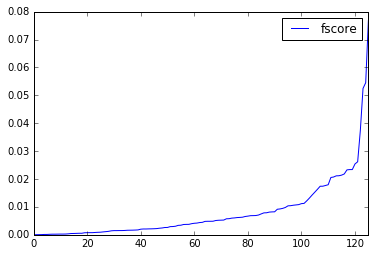

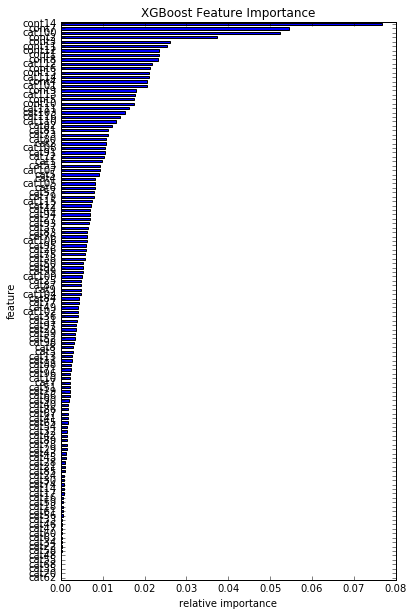

In [6]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()
    
ceate_feature_map(features)

importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

df

It's time for making our prediction.

In [7]:
test_xgb = xgb.DMatrix(test_x)
submission = pd.read_csv("../input/sample_submission.csv")
submission.iloc[:, 1] = np.exp(bst.predict(test_xgb))
submission.to_csv('xgb_starter.sub.csv', index=None)